In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [3]:
data = pickle.load(open(os.path.join(os.getcwd(), 'train_data.pickle'),'rb'))
print(data[0])
data_train = data[:int(0.9*len(data))]
data_test = data[int(0.9*len(data)):]

[array([[201., 203., 202., ..., 201., 203., 199.],
       [201., 201., 202., ..., 202., 202., 201.],
       [199., 201., 201., ..., 203., 202., 202.],
       ...,
       [144., 149., 150., ..., 170., 171., 171.],
       [141., 142., 147., ..., 169., 170., 168.],
       [122., 133., 152., ..., 170., 171., 168.]], dtype=float32), array([0, 0, 1, 0, 0])]


In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.maxpool1 = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.maxpool2 = nn.MaxPool2d(3, 3)
        self.flatten_shape = None
        x = torch.randn([50,50]).view(-1,1,50,50)
        x = self.conv(x)
        self.fc1 = nn.Linear(self.flatten_shape, 128)
        self.fc2 = nn.Linear(128, 5)
    
    def conv(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        if self.flatten_shape is None:
            self.flatten_shape = x.shape[1] * x.shape[2] * x.shape[3]
            print(x.shape)
            print(self.flatten_shape)
        return x
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flatten_shape)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
#         x = self.fc2(x)
        return x
    
    
model = Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters())
EPOCHS = 64
        
    

torch.Size([1, 8, 4, 4])
128


In [5]:
class ImageData(Dataset):
    def __init__(self, data):
        self.x = torch.Tensor([i[0].astype(np.float32)/255.0 for i in data])
        self.y = torch.Tensor([i[1] for i in data])#.long()
        self.m = self.x.shape[0]
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.m
    

dataset_train = ImageData(data_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [6]:
def train(dataloader, model, loss_function, optimizer, EPOCHS):
    model.train()
    losses = []
    for epoch in range(EPOCHS):
        epoch_losses = []
        for i, (inputs, labels) in tqdm(enumerate(dataloader)):
            inputs = inputs.view(-1, 1, 50, 50).to(device)
            
            labels = labels.view(-1,5).to(device)   
#             print(labels)
            model.zero_grad()
            optimizer.zero_grad()
            y_hat = model.forward(inputs)
#             print(y_hat)
            loss = loss_function(y_hat, labels)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss)
            if i % 16 == 0:
                losses.append(loss)
        print(np.min(epoch_losses))
    return model, losses    

In [7]:
model, losses = train(dataloader_train, model, criterion, optimizer, EPOCHS)
torch.save(model.state_dict(), os.path.join(os.getcwd(), 'model.pth'))

8it [00:01,  6.57it/s]
8it [00:00, 96.40it/s]
8it [00:00, 97.93it/s]


tensor(0.7581, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7577, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7576, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

8it [00:00, 97.82it/s]
8it [00:00, 97.82it/s]
0it [00:00, ?it/s]


tensor(0.7548, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7565, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 90.13it/s]
8it [00:00, 90.13it/s]
0it [00:00, ?it/s]

tensor(0.7543, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7520, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 96.98it/s]
8it [00:00, 94.37it/s]
0it [00:00, ?it/s]

tensor(0.7537, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7529, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 99.03it/s]
8it [00:00, 58.55it/s]
0it [00:00, ?it/s]

tensor(0.7512, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7459, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 71.62it/s]
8it [00:00, 86.25it/s]
0it [00:00, ?it/s]

tensor(0.7515, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7501, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 87.19it/s]
8it [00:00, 70.36it/s]
0it [00:00, ?it/s]

tensor(0.7481, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7439, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 59.42it/s]
8it [00:00, 82.69it/s]
0it [00:00, ?it/s]

tensor(0.7442, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7390, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 86.25it/s]
8it [00:00, 59.86it/s]
0it [00:00, ?it/s]

tensor(0.7459, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7289, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 64.69it/s]
8it [00:00, 71.62it/s]
0it [00:00, ?it/s]

tensor(0.7319, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7327, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 65.75it/s]
8it [00:00, 77.13it/s]
0it [00:00, ?it/s]

tensor(0.7264, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 56.09it/s]
8it [00:00, 89.13it/s]
0it [00:00, ?it/s]

tensor(0.7203, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 86.78it/s]
8it [00:00, 90.12it/s]
8it [00:00, 99.48it/s]


tensor(0.7112, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7009, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7097, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 99.03it/s]
8it [00:00, 95.49it/s]
8it [00:00, 102.84it/s]


tensor(0.7068, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7137, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

8it [00:00, 93.27it/s]
8it [00:00, 105.55it/s]
8it [00:00, 96.65it/s]
0it [00:00, ?it/s]


tensor(0.7052, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.7055, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6998, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 95.49it/s]
8it [00:00, 102.84it/s]
8it [00:00, 101.59it/s]
0it [00:00, ?it/s]

tensor(0.6932, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6970, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6990, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 97.67it/s]
8it [00:00, 104.18it/s]
8it [00:00, 89.13it/s]
0it [00:00, ?it/s]

tensor(0.6955, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6948, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 82.70it/s]
8it [00:00, 94.19it/s]
8it [00:00, 100.99it/s]


tensor(0.6823, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6905, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6811, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 97.82it/s]
8it [00:00, 95.14it/s]
8it [00:00, 101.54it/s]


tensor(0.6786, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6862, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

8it [00:00, 102.31it/s]
8it [00:00, 99.72it/s]
0it [00:00, ?it/s]


tensor(0.6858, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6803, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 100.27it/s]
8it [00:00, 104.17it/s]
8it [00:00, 100.73it/s]
0it [00:00, ?it/s]

tensor(0.6833, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6635, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6793, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 91.15it/s]
8it [00:00, 98.02it/s]
8it [00:00, 106.95it/s]
0it [00:00, ?it/s]

tensor(0.6807, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6682, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 92.20it/s]
8it [00:00, 106.89it/s]
8it [00:00, 93.27it/s]
0it [00:00, ?it/s]

tensor(0.6799, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6702, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6692, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 96.25it/s]
8it [00:00, 101.87it/s]
0it [00:00, ?it/s]

tensor(0.6679, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 81.02it/s]
8it [00:00, 84.43it/s]
0it [00:00, ?it/s]

tensor(0.6671, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6718, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


8it [00:00, 94.51it/s]
8it [00:00, 99.03it/s]
8it [00:00, 100.27it/s]

tensor(0.6603, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6686, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6681, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


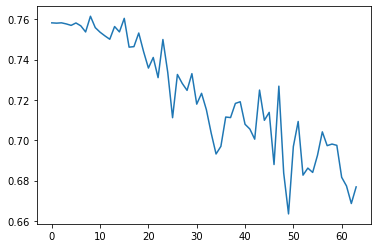

In [8]:
plt.plot(losses)

In [9]:
def validate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, (inputs, labels) in tqdm(enumerate(dataloader)):
        inputs = inputs.view(-1, 1, 50, 50).to(device)    
        labels = labels.view(-1,5).to(device)  
        
        y_hat = model.forward(inputs)
#         print(torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(labels, dim=1)))
#         print(torch.argmax(labels, dim=1))
#         break
        correct += torch.sum(torch.argmax(y_hat, dim=1) == torch.argmax(labels, dim=1))
#         print(correct)
        total += inputs.shape[0]
#         print(total)
    print(correct.item()/total)
dataset_val = ImageData(data_test)
dataloader_val = DataLoader(dataset_val, batch_size=32)
validate(model, dataloader_val)

1it [00:00, 200.52it/s]

0.7037037037037037
